## Семинар 8: "Снижение размерности"

ФИО: Якимов Борис Павлович

In [1]:
import numpy as np
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

/home/boris/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Этот семинар посвящен снижению размерности на примере данных Olivetti faces. В данных содержатся 400 черно-белых изображений 64x64. Требуется исследовать различные способы снижения размерности: PCA и Автокодировщик

In [2]:
dataset = fetch_olivetti_faces()
X = dataset['data']

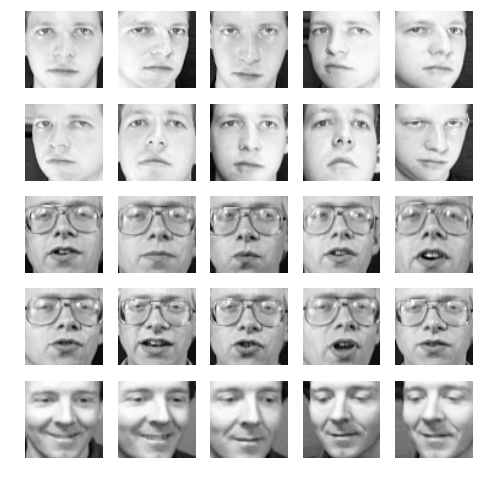

In [3]:
plt.figure(figsize=(8, 8))
for i in xrange(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(64, 64), cmap=plt.cm.Greys_r)
    plt.axis('off')
plt.show()

### Часть 1: PCA

In [4]:
from sklearn.decomposition import PCA

<i> 1.1 Примените алгоритм PCA к данным и отобразите главные компоненты. В качестве числа компонент выберите 25</i>

In [5]:
pca = PCA(n_components=25)

In [6]:
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=25, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [7]:
exp_variance = pca.explained_variance_
exp_variance = np.cumsum(exp_variance)/np.sum(exp_variance)

In [8]:
components = pca.components_

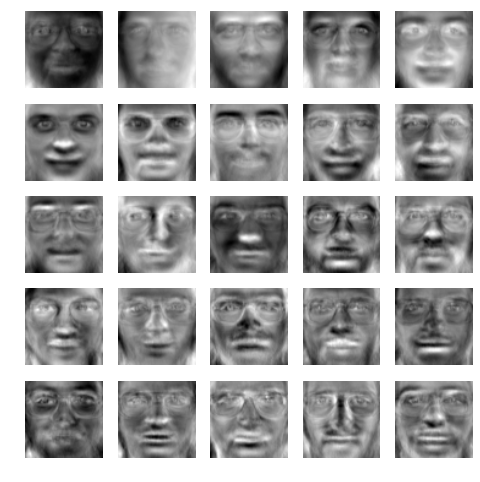

In [9]:
plt.figure(figsize=(8,8))
for i,pic in enumerate(components):
    plt.subplot(5,5,i + 1)
    plt.imshow(np.reshape(pic,(64,64)),cmap='gray')
    plt.axis('off')

<i> 1.2 Отобразите зависимость качества восстановления от количества компонент</i>
Подсказка: используйте методы <b>.transform</b> и <b>.inverse_transform</b>

In [10]:
import tqdm

In [11]:
components = pca.components_

In [12]:
errors = []
for i in tqdm.tqdm_notebook(xrange(1,400,10)):
    pca = PCA(n_components=i)
    pca.fit(X)
    errors.append(np.linalg.norm(X - pca.inverse_transform(pca.transform(X))))

В качестве ошибки была взята норма Фробениуса между исходной матрицей объектов признаков и восстановленной матрицей

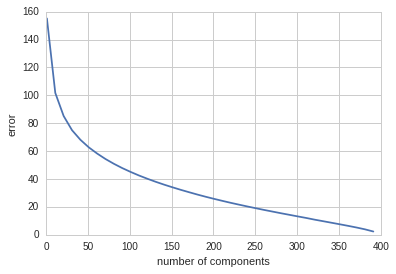

In [13]:
plt.plot(range(1,400,10),errors)
plt.xlabel('number of components')
plt.ylabel('error')

<i>1.3 Какое количество компонент следует выбирать, чтобы соблюсти баланс размерность — качество?</i>

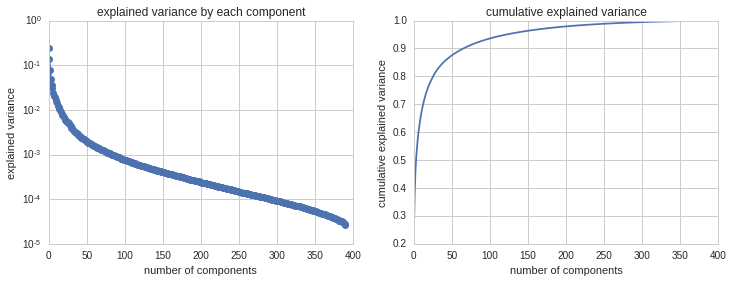

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.semilogy(pca.explained_variance_ratio_,'o-')
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.title('explained variance by each component')

plt.subplot(1,2,2)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('cumulative explained variance')

Если попробовать найти "trade-off" между правилом локтя и объясненной дисперсией, то количество главных компонент следует выбрать равным 50.

<i>1.4 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [15]:
pca = PCA(n_components=2)
X_2d  = pca.fit_transform(X)

In [65]:
def plot_dataset(X, x, y, margin=50, frame=2000., imsize=64):
    x1 = (x - x.min()) * (frame / (x.max() - x.min())) + margin
    y1 = (y - y.min()) * (frame / (y.max() - y.min())) + margin
    x1 = x1.astype('uint16')
    y1 = y1.astype('uint16')
    image = np.zeros((int(x1.max() + margin + imsize), int(y1.max() + margin + imsize)))+ 1.0
    print "Image size is %dx%d" % image.shape
    for k in xrange(X.shape[0]):
        image[y1[k]:y1[k]+64,x1[k]:x1[k]+64] = X[k].reshape(64,64)
    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

Image size is 2164x2164


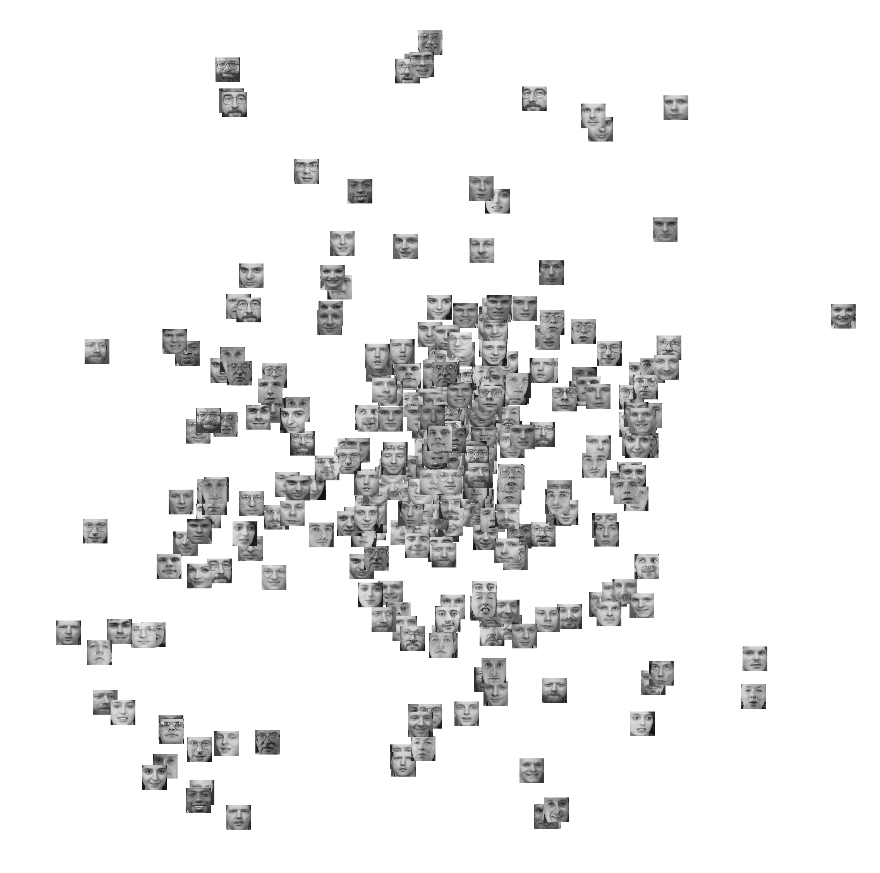

In [66]:
plt.figure(figsize=(8,8))
plot_dataset(X,X_2d[:,0],X_2d[:,1])

Можно сказать, что перва переменная в себя включает переход от светлых изображений к темным и (отчасти) безбородых к бородатым. Явно выделился кластер темных фотографий. :) Также группируются в более плотные участки фотографии одного и того же человека, выполненные из разных ракурсов. Но это не точно.

###  Часть 2: Автокодировщик

<i> 2.1 Обучите автокодировщик с архитектурой 4096 -> 200 -> 10 -> 200 -> 4096. В качестве нелинейностей используйте сигмоиду.</i>

In [18]:
class Autoencoder(nn.Module):
    def __init__(self,output_size=10):
        super(Autoencoder, self).__init__()

        self.fc1 = nn.Linear(4096, 200)
        self.fc2 = nn.Linear(200,output_size)
        self.fc3 = nn.Linear(output_size,200)
        self.fc4 = nn.Linear(200, 4096)
        self.nonlinearity = nn.Tanh()

    def encode(self, x):
        h1 = self.nonlinearity(self.fc1(x))
        h2 = self.fc2(h1)
        return h2

    def decode(self, z):
        
        h3 = self.nonlinearity(self.fc3(self.nonlinearity(z)))
        h4 = self.nonlinearity(self.fc4(h3))
        return h4

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)


def train(data,batch_size):
    model.train()
    train_loss = [] 
    
    for i in tqdm.tqdm_notebook(xrange(0,data.shape[0]-batch_size,batch_size),desc='train loop',leave=False):
        x = torch.from_numpy(data[i:i+batch_size]).type(torch.FloatTensor)
        x = Variable(x)    
        
        optimizer.zero_grad()
        recon_batch = model(x)
        loss = loss_fn(recon_batch, x)
        train_loss.append(loss.data[0])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_loss = np.mean(train_loss)
    #print "mean train loss over epoch:",mean_loss
    return mean_loss
    

def test(data,batch_size):
    model.eval()
    test_loss = []
    for i in tqdm.tqdm_notebook(xrange(0,data.shape[0]-batch_size,batch_size),desc='test loop',leave=False):
        x = Variable(torch.from_numpy(data[i:i+batch_size]).type(torch.FloatTensor),volatile=True)
        recon_batch = model(x)
        test_loss.append(loss_fn(recon_batch, x).data[0])
    
    mean_loss = np.mean(test_loss)
    #print "mean test loss over epoch:",mean_loss
    return mean_loss

def elementwise_encoding(model,data,output_size):
    model.eval()
    res = np.zeros((data.shape[0],output_size))
    for i in tqdm.tqdm_notebook(xrange(data.shape[0]-1),desc='encoding',leave=False):
        x = Variable(torch.from_numpy(data[i:i+1]).type(torch.FloatTensor),volatile=True)
        z = model.encode(x)
        res[i,:] = z.data[0].numpy()
        
    return res

def elementwise_decoding(model,encoded_data,output_size=4096):
    model.eval()
    res = np.zeros((encoded_data.shape[0],output_size))
    for i in tqdm.tqdm_notebook(xrange(encoded_data.shape[0]-1),desc='decoding',leave=False):
        x = Variable(torch.from_numpy(encoded_data[i:i+1]).type(torch.FloatTensor),volatile=True)
        z = model.decode(x)
        res[i,:] = z.data[0].numpy()
        
    return res

Стандартизуем каждое изображение:

In [19]:
X_scaled = (X - np.mean(X,axis=1).reshape(400,1))/np.std(X,axis=1).reshape(400,1) 

In [20]:
output_size = 10
model = Autoencoder(output_size=output_size)
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-5)

In [21]:
n_epochs = 200   
batch_size = 10
verbose = True

np.random.shuffle(X)
data_train = X_scaled
#data_test = X_scaled[-20:]

train_loss = []
#test_loss = []

for i in tqdm.tqdm_notebook(xrange(n_epochs),desc = 'training network'):
    np.random.shuffle(data_train)
    train_loss.append(train(data_train,batch_size))
    if verbose:
        if i%5 == 0:
            print "Epoch no.:",i
            print "train loss",train_loss[-1]
            #print "test loss", test_loss[-1]


Epoch no.: 0
train loss 0.681602936525
Epoch no.: 5
train loss 0.426943407609
Epoch no.: 10
train loss 0.385309567818
Epoch no.: 15
train loss 0.371027973982
Epoch no.: 20
train loss 0.359063848471
Epoch no.: 25
train loss 0.354530477371
Epoch no.: 30
train loss 0.350769469371
Epoch no.: 35
train loss 0.344438411486
Epoch no.: 40
train loss 0.340890046114
Epoch no.: 45
train loss 0.336196640363
Epoch no.: 50
train loss 0.331333247515
Epoch no.: 55
train loss 0.326769398573
Epoch no.: 60
train loss 0.324535083312
Epoch no.: 65
train loss 0.321844442533
Epoch no.: 70
train loss 0.319880712491
Epoch no.: 75
train loss 0.318767623259
Epoch no.: 80
train loss 0.316113588902
Epoch no.: 85
train loss 0.312898932359
Epoch no.: 90
train loss 0.309633114399
Epoch no.: 95
train loss 0.309033296047
Epoch no.: 100
train loss 0.308413523894
Epoch no.: 105
train loss 0.30428029635
Epoch no.: 110
train loss 0.30548695494
Epoch no.: 115
train loss 0.305857876172
Epoch no.: 120
train loss 0.303643166255

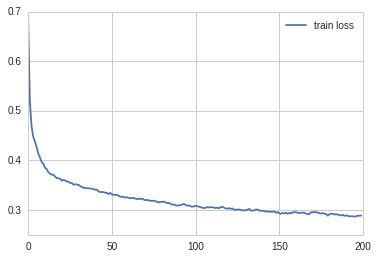

In [22]:
plt.plot(train_loss,label='train loss')
plt.legend()

При использовании сигмоиды наблюдалось сильное недообучение, поэтому решил изменить нелинейность на на гиперболические тангенсы. Ситуация при фиксированной скорости обучения и скорости распада заметно улучшилась.

<i> 2.2 Какое качество восстановления удалось получить?</i>
<i> 2.3 Обучите сеть с разными размерностями пространства, в которое происходит отображение </i>
<i> 2.4 Сравните графики из пунктов 1.2 и 2.3 </i>

In [25]:
errs = []
n_epochs = 200
for output_size in xrange(1,200,20):
    model = Autoencoder(output_size=output_size)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-5)
    
    for i in tqdm.tqdm_notebook(xrange(n_epochs),desc = 'training network'):
        np.random.shuffle(data_train)
        train_loss.append(train(data_train,batch_size))

    encoded_data = elementwise_encoding(model=model,data=X_scaled,output_size=output_size)
    err = np.linalg.norm(X_scaled - elementwise_decoding(model,encoded_data))
    print "output size is %i, error is %.3f"%(output_size,err)
    errs.append(err)
    


output size is 1, error is 897.180

output size is 21, error is 644.846

output size is 41, error is 621.728

output size is 61, error is 609.507

output size is 81, error is 605.216

output size is 101, error is 594.532

output size is 121, error is 594.567

output size is 141, error is 592.044

output size is 161, error is 595.109

output size is 181, error is 588.724


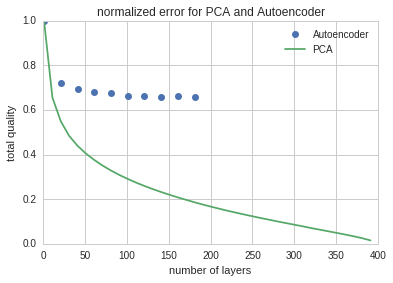

In [41]:
plt.plot(range(1,200,20),errs/max(errs),'o',label='Autoencoder')
plt.xlabel('number of layers')
plt.ylabel('total quality')
plt.plot(range(1,400,10),errors/max(errors),label='PCA')
plt.title('normalized error for PCA and Autoencoder')
plt.legend()

Кажется, что оптимальным количеством нейронов на выходном слое будет порядка 50 - 60. Однако очевидно, что при таком количестве нейронов нейросеть просто запомнит весь датасет и не будет обладать обобщающей способностью, достаточно лишь долгое время обучать нейросеть (кажется - особенно с сигмоидальной нелинейностью - автокодировщик относительно медленно учится). 

Также могу предположить, что поскольку я не изменял количество эпох для нейросетей с различной архитектурой, то сети с большей размерностью пространства, в которое происходит отображение, просто "недоучиваются" до своих принципиальных достижимых уровней "качества отображения".  

<i> 2.5 Отобразите данные на плоскости (количество компонент = 2). Выделились ли какие-нибудь кластеры? Если да, чему они соответствуют?</i>

In [27]:
output_size = 2
model = Autoencoder(output_size=output_size)
loss_fn = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=5e-5)

In [70]:
n_epochs = 300   
batch_size = 10

train_loss = []

for i in tqdm.tqdm_notebook(xrange(n_epochs),desc = 'training network'):
    np.random.shuffle(data_train)
    train(data_train,batch_size)


In [71]:
X_scaled = (X - np.mean(X,axis=1).reshape(400,1))/np.std(X,axis=1).reshape(400,1) 
X_2d = elementwise_encoding(model,X_scaled,output_size)

Image size is 2164x2164


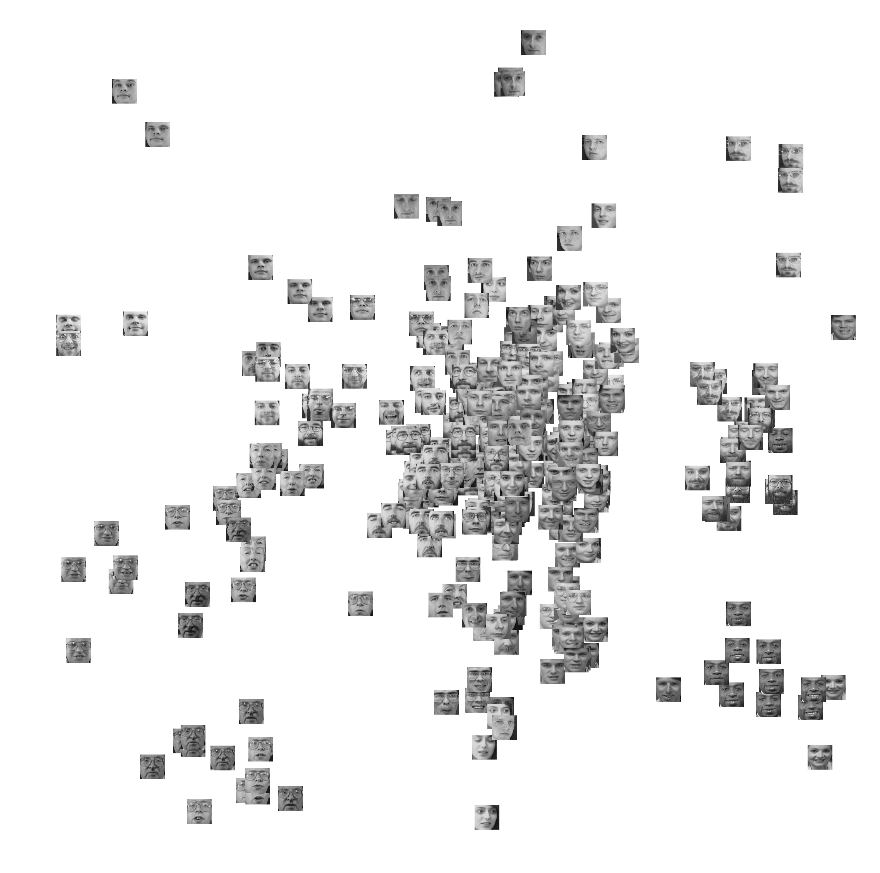

In [72]:
plt.figure(figsize=(8,8))
plot_dataset(X,X_2d[:,0],X_2d[:,1])

При достаточно долгом обучении видно, что фотографии начинают разделяться в отдельные кластерые, в каждом из которых фотографии одного человека. Однако чётко выделенные кластеры мне получить не удалось, но думаю, что необходимо просто дольше обучаться. 

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: